In [1]:
# https://github.com/huggingface/peft/blob/main/examples/sequence_classification/P_Tuning.ipynb

In [ ]:
!pip install accelerate -U
!pip install transformers datasets evaluate accelerate peft

In [5]:
from google.colab import drive
import pandas as pd
import os
import torch
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup
from peft import (
    get_peft_config,
    get_peft_model,
    get_peft_model_state_dict,
    set_peft_model_state_dict,
    PeftType,
    PromptEncoderConfig
)

In [6]:
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/Colab Notebooks/Comp545_FinalProject/code')

from model.train import training_loop
from model.evaluate import evaluate_model
from utils.funcs import load_data, load_tokenizer_model, prepare_dataloader
from utils.plot import plot_confusion_matrix
from utils.test_cases import run_test_cases

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

Mounted at /content/drive


## Train and evaluate on combine data

In [7]:
train_combine_data_path = "../data_PEFT/lab-manual-combine-train.xlsx"
test_combine_data_path = "../data_PEFT/lab-manual-combine-test.xlsx"

sentences_combine, labels_combine, sentences_test_combine, labels_test_combine = load_data(train_combine_data_path, test_combine_data_path)

In [8]:
language_model_to_use = 'roberta-large'
batch_size = 16

train_val_dataloader_combine = prepare_dataloader(language_model_to_use, sentences_combine, labels_combine, batch_size, device, return_train_dataloader=True)
test_dataloader_combine = prepare_dataloader(language_model_to_use, sentences_test_combine, labels_test_combine, batch_size, device, return_train_dataloader=False)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Train Size: 4568, Validation Size: 1141


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Test Size: 1428


In [ ]:
peft_config = PromptEncoderConfig(task_type="SEQ_CLS", peft_type="P_TUNING", num_virtual_tokens=20, encoder_hidden_size=128)
peft_type = PeftType.P_TUNING

tokenizer, model = load_tokenizer_model(language_model_to_use, device)
model_p_tuning = get_peft_model(model, peft_config)
model_p_tuning.print_trainable_parameters()
model_p_tuning
# trainable params: 1,352,963 || all params: 356,715,782 || trainable%: 0.3792831907840848

In [10]:
optimizer = AdamW(params=model.parameters(), lr=5e-3)
num_epochs = 20
num_training_steps = len(train_val_dataloader_combine['train']) * num_epochs

# Instantiate scheduler
lr_scheduler = get_linear_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=0.06 * (len(train_val_dataloader_combine['train']) * num_epochs),
    num_training_steps=num_training_steps,
)

In [11]:
accuracy_list, f1_list = training_loop(model_p_tuning, device, num_epochs, train_val_dataloader_combine, optimizer, lr_scheduler)

100%|██████████| 286/286 [02:28<00:00,  1.92it/s]


Epoch [1/20], Training loss: 1.0546


100%|██████████| 72/72 [00:17<00:00,  4.05it/s]


Epoch [1/20], Validation accuracy:
{'accuracy': 0.2988606485539001}
Epoch [1/20], Validation f1:
{'f1': 0.17533484894632262}
---------------------------------------------------


100%|██████████| 286/286 [02:23<00:00,  1.99it/s]


Epoch [2/20], Training loss: 1.0448


100%|██████████| 72/72 [00:17<00:00,  4.06it/s]


Epoch [2/20], Validation accuracy:
{'accuracy': 0.3339176161262051}
Epoch [2/20], Validation f1:
{'f1': 0.252781793000809}
---------------------------------------------------


100%|██████████| 286/286 [02:23<00:00,  1.99it/s]


Epoch [3/20], Training loss: 1.4950


100%|██████████| 72/72 [00:17<00:00,  4.06it/s]


Epoch [3/20], Validation accuracy:
{'accuracy': 0.4680105170902717}
Epoch [3/20], Validation f1:
{'f1': 0.3105734784667679}
---------------------------------------------------


100%|██████████| 286/286 [02:23<00:00,  1.99it/s]


Epoch [4/20], Training loss: 0.7229


100%|██████████| 72/72 [00:17<00:00,  4.07it/s]


Epoch [4/20], Validation accuracy:
{'accuracy': 0.5004382120946538}
Epoch [4/20], Validation f1:
{'f1': 0.4167807879100642}
---------------------------------------------------


100%|██████████| 286/286 [02:23<00:00,  1.99it/s]


Epoch [5/20], Training loss: 1.2433


100%|██████████| 72/72 [00:17<00:00,  4.06it/s]


Epoch [5/20], Validation accuracy:
{'accuracy': 0.45924627519719546}
Epoch [5/20], Validation f1:
{'f1': 0.41095727254153813}
---------------------------------------------------


100%|██████████| 286/286 [02:23<00:00,  1.99it/s]


Epoch [6/20], Training loss: 0.8501


100%|██████████| 72/72 [00:17<00:00,  4.06it/s]


Epoch [6/20], Validation accuracy:
{'accuracy': 0.5644171779141104}
Epoch [6/20], Validation f1:
{'f1': 0.5148690159792496}
---------------------------------------------------


100%|██████████| 286/286 [02:23<00:00,  1.99it/s]


Epoch [7/20], Training loss: 0.7742


100%|██████████| 72/72 [00:17<00:00,  4.07it/s]


Epoch [7/20], Validation accuracy:
{'accuracy': 0.5670464504820333}
Epoch [7/20], Validation f1:
{'f1': 0.5705811877299041}
---------------------------------------------------


100%|██████████| 286/286 [02:23<00:00,  1.99it/s]


Epoch [8/20], Training loss: 0.9589


100%|██████████| 72/72 [00:17<00:00,  4.04it/s]


Epoch [8/20], Validation accuracy:
{'accuracy': 0.6056091148115688}
Epoch [8/20], Validation f1:
{'f1': 0.6058614871862295}
---------------------------------------------------


100%|██████████| 286/286 [02:23<00:00,  1.99it/s]


Epoch [9/20], Training loss: 0.6215


100%|██████████| 72/72 [00:17<00:00,  4.06it/s]


Epoch [9/20], Validation accuracy:
{'accuracy': 0.530236634531113}
Epoch [9/20], Validation f1:
{'f1': 0.5267197700397008}
---------------------------------------------------


100%|██████████| 286/286 [02:23<00:00,  1.99it/s]


Epoch [10/20], Training loss: 0.6210


100%|██████████| 72/72 [00:17<00:00,  4.06it/s]


Epoch [10/20], Validation accuracy:
{'accuracy': 0.6047326906222612}
Epoch [10/20], Validation f1:
{'f1': 0.6059607124773075}
---------------------------------------------------


100%|██████████| 286/286 [02:23<00:00,  1.99it/s]


Epoch [11/20], Training loss: 0.8532


100%|██████████| 72/72 [00:17<00:00,  4.06it/s]


Epoch [11/20], Validation accuracy:
{'accuracy': 0.6231375985977213}
Epoch [11/20], Validation f1:
{'f1': 0.6113076741233148}
---------------------------------------------------


100%|██████████| 286/286 [02:23<00:00,  1.99it/s]


Epoch [12/20], Training loss: 0.9572


100%|██████████| 72/72 [00:17<00:00,  4.05it/s]


Epoch [12/20], Validation accuracy:
{'accuracy': 0.5591586327782647}
Epoch [12/20], Validation f1:
{'f1': 0.47815007367184875}
---------------------------------------------------


100%|██████████| 286/286 [02:23<00:00,  1.99it/s]


Epoch [13/20], Training loss: 1.0020


100%|██████████| 72/72 [00:17<00:00,  4.06it/s]


Epoch [13/20], Validation accuracy:
{'accuracy': 0.635407537248028}
Epoch [13/20], Validation f1:
{'f1': 0.6319199848033298}
---------------------------------------------------


100%|██████████| 286/286 [02:23<00:00,  1.99it/s]


Epoch [14/20], Training loss: 0.7492


100%|██████████| 72/72 [00:17<00:00,  4.06it/s]


Epoch [14/20], Validation accuracy:
{'accuracy': 0.5994741454864154}
Epoch [14/20], Validation f1:
{'f1': 0.5430866336019011}
---------------------------------------------------


100%|██████████| 286/286 [02:23<00:00,  1.99it/s]


Epoch [15/20], Training loss: 1.4054


100%|██████████| 72/72 [00:17<00:00,  4.06it/s]


Epoch [15/20], Validation accuracy:
{'accuracy': 0.5670464504820333}
Epoch [15/20], Validation f1:
{'f1': 0.5063608455211155}
---------------------------------------------------


100%|██████████| 286/286 [02:23<00:00,  1.99it/s]


Epoch [16/20], Training loss: 1.2651


100%|██████████| 72/72 [00:17<00:00,  4.05it/s]


Epoch [16/20], Validation accuracy:
{'accuracy': 0.6546888694127958}
Epoch [16/20], Validation f1:
{'f1': 0.6421730711474964}
---------------------------------------------------


100%|██████████| 286/286 [02:23<00:00,  1.99it/s]


Epoch [17/20], Training loss: 0.8283


100%|██████████| 72/72 [00:17<00:00,  4.05it/s]


Epoch [17/20], Validation accuracy:
{'accuracy': 0.6713409290096407}
Epoch [17/20], Validation f1:
{'f1': 0.6693037736085018}
---------------------------------------------------


100%|██████████| 286/286 [02:23<00:00,  1.99it/s]


Epoch [18/20], Training loss: 0.5749


100%|██████████| 72/72 [00:17<00:00,  4.06it/s]


Epoch [18/20], Validation accuracy:
{'accuracy': 0.6836108676599474}
Epoch [18/20], Validation f1:
{'f1': 0.6802762615555609}
---------------------------------------------------


100%|██████████| 286/286 [02:23<00:00,  1.99it/s]


Epoch [19/20], Training loss: 0.7751


100%|██████████| 72/72 [00:17<00:00,  4.06it/s]


Epoch [19/20], Validation accuracy:
{'accuracy': 0.6879929886064855}
Epoch [19/20], Validation f1:
{'f1': 0.6865741544834868}
---------------------------------------------------


100%|██████████| 286/286 [02:23<00:00,  1.99it/s]


Epoch [20/20], Training loss: 0.4127


100%|██████████| 72/72 [00:17<00:00,  4.06it/s]

Epoch [20/20], Validation accuracy:
{'accuracy': 0.6862401402278703}
Epoch [20/20], Validation f1:
{'f1': 0.6838566696902156}
---------------------------------------------------


In [12]:
accuracy_list

[{'accuracy': 0.2988606485539001},
 {'accuracy': 0.3339176161262051},
 {'accuracy': 0.4680105170902717},
 {'accuracy': 0.5004382120946538},
 {'accuracy': 0.45924627519719546},
 {'accuracy': 0.5644171779141104},
 {'accuracy': 0.5670464504820333},
 {'accuracy': 0.6056091148115688},
 {'accuracy': 0.530236634531113},
 {'accuracy': 0.6047326906222612},
 {'accuracy': 0.6231375985977213},
 {'accuracy': 0.5591586327782647},
 {'accuracy': 0.635407537248028},
 {'accuracy': 0.5994741454864154},
 {'accuracy': 0.5670464504820333},
 {'accuracy': 0.6546888694127958},
 {'accuracy': 0.6713409290096407},
 {'accuracy': 0.6836108676599474},
 {'accuracy': 0.6879929886064855},
 {'accuracy': 0.6862401402278703}]

In [13]:
f1_list

[{'f1': 0.17533484894632262},
 {'f1': 0.252781793000809},
 {'f1': 0.3105734784667679},
 {'f1': 0.4167807879100642},
 {'f1': 0.41095727254153813},
 {'f1': 0.5148690159792496},
 {'f1': 0.5705811877299041},
 {'f1': 0.6058614871862295},
 {'f1': 0.5267197700397008},
 {'f1': 0.6059607124773075},
 {'f1': 0.6113076741233148},
 {'f1': 0.47815007367184875},
 {'f1': 0.6319199848033298},
 {'f1': 0.5430866336019011},
 {'f1': 0.5063608455211155},
 {'f1': 0.6421730711474964},
 {'f1': 0.6693037736085018},
 {'f1': 0.6802762615555609},
 {'f1': 0.6865741544834868},
 {'f1': 0.6838566696902156}]

In [14]:
accuracy, f1, predictions_list, labels_list = evaluate_model(model_p_tuning, test_dataloader_combine, device)

Test accuracy:  {'accuracy': 0.6792717086834734}
Test f1:  {'f1': 0.678370825557306}


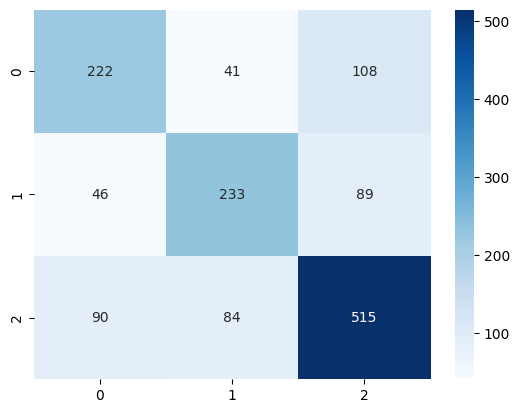

In [15]:
plot_confusion_matrix(labels_list, predictions_list)

In [16]:
# test some cases
p_tuning_model_combinedata_name = 'p_tuning-model-combinedata'
p_tuning_tokenizer_combinedata_name = 'p_tuning-tokenizer-combinedata'

# Save model
tokenizer.save_pretrained(p_tuning_tokenizer_combinedata_name)
model_p_tuning.save_pretrained(p_tuning_model_combinedata_name)

run_test_cases(p_tuning_model_combinedata_name, p_tuning_tokenizer_combinedata_name)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Example 1
The Committee anticipates that ongoing increases in the target range for the federal funds rate will be appropriate.
correct answer: Hawkish
predicted classification:  Neutral
Example 2
In light of the softer economic outlook, we will maintain the current federal funds rate.
correct answer: Dovish
predicted classification:  Hawkish
Example 3
Economic activity has been rising at a strong rate.
correct answer: Neutral
predicted classification:  Hawkish
Example 4
Considering the elevated inflation pressures, we may consider further rate hikes.
correct answer: Hawkish
predicted classification:  Hawkish
Example 5
The labor market continues to strengthen, but inflation remains below our 2 percent longer-run objective.
correct answer: Dovish
predicted classification:  Hawkish


## Train and evaluate on split combine data

In [17]:
train_split_combine_data_path = "../data_PEFT/lab-manual-split-combine-train.xlsx"
test_split_combine_data_path = "../data_PEFT/lab-manual-split-combine-test.xlsx"

sentences_split_combine, labels_split_combine, sentences_test_split_combine, labels_test_split_combine = load_data(train_split_combine_data_path,
                                                                                                                   test_split_combine_data_path)

In [18]:
language_model_to_use = 'roberta-large'
batch_size = 16

train_val_dataloader_split_combine = prepare_dataloader(language_model_to_use,
                                                        sentences_split_combine,
                                                        labels_split_combine,
                                                        batch_size,
                                                        device,
                                                        return_train_dataloader=True)
test_dataloader_split_combine = prepare_dataloader(language_model_to_use,
                                                   sentences_test_split_combine,
                                                   labels_test_split_combine,
                                                   batch_size,
                                                   device,
                                                   return_train_dataloader=False)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Train Size: 4762, Validation Size: 1190


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Test Size: 1488


In [19]:
peft_config = PromptEncoderConfig(task_type="SEQ_CLS", peft_type="P_TUNING", num_virtual_tokens=20, encoder_hidden_size=128)
peft_type = PeftType.P_TUNING

tokenizer, model = load_tokenizer_model(language_model_to_use, device)
model_p_tuning = get_peft_model(model, peft_config)
model_p_tuning.print_trainable_parameters()
model_p_tuning

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 1,352,963 || all params: 356,715,782 || trainable%: 0.3792831907840848


PeftModelForSequenceClassification(
  (base_model): RobertaForSequenceClassification(
    (roberta): RobertaModel(
      (embeddings): RobertaEmbeddings(
        (word_embeddings): Embedding(50265, 1024, padding_idx=1)
        (position_embeddings): Embedding(514, 1024, padding_idx=1)
        (token_type_embeddings): Embedding(1, 1024)
        (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): RobertaEncoder(
        (layer): ModuleList(
          (0-23): 24 x RobertaLayer(
            (attention): RobertaAttention(
              (self): RobertaSelfAttention(
                (query): Linear(in_features=1024, out_features=1024, bias=True)
                (key): Linear(in_features=1024, out_features=1024, bias=True)
                (value): Linear(in_features=1024, out_features=1024, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): RobertaS

In [20]:
optimizer = AdamW(params=model.parameters(), lr=5e-3)
num_epochs = 20
num_training_steps = len(train_val_dataloader_combine['train']) * num_epochs

# Instantiate scheduler
lr_scheduler = get_linear_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=0.06 * (len(train_val_dataloader_combine['train']) * num_epochs),
    num_training_steps=num_training_steps,
)

In [21]:
accuracy_list_splitdata, f1_list_splitdata = training_loop(model_p_tuning,
                                                           device,
                                                           num_epochs,
                                                           train_val_dataloader_split_combine,
                                                           optimizer,
                                                           lr_scheduler)

100%|██████████| 298/298 [02:34<00:00,  1.93it/s]


Epoch [1/20], Training loss: 1.7815


100%|██████████| 75/75 [00:18<00:00,  4.06it/s]


Epoch [1/20], Validation accuracy:
{'accuracy': 0.5067226890756302}
Epoch [1/20], Validation f1:
{'f1': 0.34082965032080875}
---------------------------------------------------


100%|██████████| 298/298 [02:29<00:00,  1.99it/s]


Epoch [2/20], Training loss: 1.2834


100%|██████████| 75/75 [00:18<00:00,  4.06it/s]


Epoch [2/20], Validation accuracy:
{'accuracy': 0.5067226890756302}
Epoch [2/20], Validation f1:
{'f1': 0.34082965032080875}
---------------------------------------------------


100%|██████████| 298/298 [02:29<00:00,  1.99it/s]


Epoch [3/20], Training loss: 0.9170


100%|██████████| 75/75 [00:18<00:00,  4.05it/s]


Epoch [3/20], Validation accuracy:
{'accuracy': 0.33613445378151263}
Epoch [3/20], Validation f1:
{'f1': 0.32449746837840915}
---------------------------------------------------


100%|██████████| 298/298 [02:29<00:00,  1.99it/s]


Epoch [4/20], Training loss: 1.4699


100%|██████████| 75/75 [00:18<00:00,  4.06it/s]


Epoch [4/20], Validation accuracy:
{'accuracy': 0.5025210084033613}
Epoch [4/20], Validation f1:
{'f1': 0.3581157384771599}
---------------------------------------------------


100%|██████████| 298/298 [02:29<00:00,  1.99it/s]


Epoch [5/20], Training loss: 1.1144


100%|██████████| 75/75 [00:18<00:00,  4.05it/s]


Epoch [5/20], Validation accuracy:
{'accuracy': 0.44537815126050423}
Epoch [5/20], Validation f1:
{'f1': 0.4014645730700574}
---------------------------------------------------


100%|██████████| 298/298 [02:29<00:00,  1.99it/s]


Epoch [6/20], Training loss: 1.2734


100%|██████████| 75/75 [00:18<00:00,  4.06it/s]


Epoch [6/20], Validation accuracy:
{'accuracy': 0.31176470588235294}
Epoch [6/20], Validation f1:
{'f1': 0.21265474781393132}
---------------------------------------------------


100%|██████████| 298/298 [02:29<00:00,  1.99it/s]


Epoch [7/20], Training loss: 0.8346


100%|██████████| 75/75 [00:18<00:00,  4.06it/s]


Epoch [7/20], Validation accuracy:
{'accuracy': 0.49495798319327733}
Epoch [7/20], Validation f1:
{'f1': 0.4519649962266574}
---------------------------------------------------


100%|██████████| 298/298 [02:29<00:00,  1.99it/s]


Epoch [8/20], Training loss: 1.1877


100%|██████████| 75/75 [00:18<00:00,  4.04it/s]


Epoch [8/20], Validation accuracy:
{'accuracy': 0.5336134453781513}
Epoch [8/20], Validation f1:
{'f1': 0.4654957504024173}
---------------------------------------------------


100%|██████████| 298/298 [02:29<00:00,  1.99it/s]


Epoch [9/20], Training loss: 1.1792


100%|██████████| 75/75 [00:18<00:00,  4.05it/s]


Epoch [9/20], Validation accuracy:
{'accuracy': 0.5235294117647059}
Epoch [9/20], Validation f1:
{'f1': 0.4459203901015522}
---------------------------------------------------


100%|██████████| 298/298 [02:29<00:00,  1.99it/s]


Epoch [10/20], Training loss: 1.0767


100%|██████████| 75/75 [00:18<00:00,  4.05it/s]


Epoch [10/20], Validation accuracy:
{'accuracy': 0.5470588235294118}
Epoch [10/20], Validation f1:
{'f1': 0.504325259515571}
---------------------------------------------------


100%|██████████| 298/298 [02:29<00:00,  1.99it/s]


Epoch [11/20], Training loss: 0.9648


100%|██████████| 75/75 [00:18<00:00,  4.05it/s]


Epoch [11/20], Validation accuracy:
{'accuracy': 0.5411764705882353}
Epoch [11/20], Validation f1:
{'f1': 0.4902454967342344}
---------------------------------------------------


100%|██████████| 298/298 [02:29<00:00,  1.99it/s]


Epoch [12/20], Training loss: 1.0958


100%|██████████| 75/75 [00:18<00:00,  4.05it/s]


Epoch [12/20], Validation accuracy:
{'accuracy': 0.5764705882352941}
Epoch [12/20], Validation f1:
{'f1': 0.5452223781244757}
---------------------------------------------------


100%|██████████| 298/298 [02:29<00:00,  1.99it/s]


Epoch [13/20], Training loss: 0.8130


100%|██████████| 75/75 [00:18<00:00,  4.05it/s]


Epoch [13/20], Validation accuracy:
{'accuracy': 0.5773109243697478}
Epoch [13/20], Validation f1:
{'f1': 0.5478431948510442}
---------------------------------------------------


100%|██████████| 298/298 [02:29<00:00,  1.99it/s]


Epoch [14/20], Training loss: 0.8732


100%|██████████| 75/75 [00:18<00:00,  4.06it/s]


Epoch [14/20], Validation accuracy:
{'accuracy': 0.592436974789916}
Epoch [14/20], Validation f1:
{'f1': 0.5752635422160175}
---------------------------------------------------


100%|██████████| 298/298 [02:29<00:00,  1.99it/s]


Epoch [15/20], Training loss: 0.9035


100%|██████████| 75/75 [00:18<00:00,  4.05it/s]


Epoch [15/20], Validation accuracy:
{'accuracy': 0.5302521008403361}
Epoch [15/20], Validation f1:
{'f1': 0.48713865491991926}
---------------------------------------------------


100%|██████████| 298/298 [02:29<00:00,  1.99it/s]


Epoch [16/20], Training loss: 1.0587


100%|██████████| 75/75 [00:18<00:00,  4.04it/s]


Epoch [16/20], Validation accuracy:
{'accuracy': 0.6016806722689075}
Epoch [16/20], Validation f1:
{'f1': 0.5605903185518047}
---------------------------------------------------


100%|██████████| 298/298 [02:29<00:00,  1.99it/s]


Epoch [17/20], Training loss: 0.9691


100%|██████████| 75/75 [00:18<00:00,  4.05it/s]


Epoch [17/20], Validation accuracy:
{'accuracy': 0.6134453781512605}
Epoch [17/20], Validation f1:
{'f1': 0.6183491235635439}
---------------------------------------------------


100%|██████████| 298/298 [02:29<00:00,  1.99it/s]


Epoch [18/20], Training loss: 0.9982


100%|██████████| 75/75 [00:18<00:00,  4.04it/s]


Epoch [18/20], Validation accuracy:
{'accuracy': 0.6168067226890757}
Epoch [18/20], Validation f1:
{'f1': 0.6180123824149496}
---------------------------------------------------


100%|██████████| 298/298 [02:29<00:00,  1.99it/s]


Epoch [19/20], Training loss: 1.0819


100%|██████████| 75/75 [00:18<00:00,  4.04it/s]


Epoch [19/20], Validation accuracy:
{'accuracy': 0.6361344537815126}
Epoch [19/20], Validation f1:
{'f1': 0.6312822368650283}
---------------------------------------------------


100%|██████████| 298/298 [02:29<00:00,  1.99it/s]


Epoch [20/20], Training loss: 0.4887


100%|██████████| 75/75 [00:18<00:00,  4.04it/s]

Epoch [20/20], Validation accuracy:
{'accuracy': 0.6445378151260505}
Epoch [20/20], Validation f1:
{'f1': 0.6416344394184553}
---------------------------------------------------


In [22]:
accuracy_list_splitdata

[{'accuracy': 0.5067226890756302},
 {'accuracy': 0.5067226890756302},
 {'accuracy': 0.33613445378151263},
 {'accuracy': 0.5025210084033613},
 {'accuracy': 0.44537815126050423},
 {'accuracy': 0.31176470588235294},
 {'accuracy': 0.49495798319327733},
 {'accuracy': 0.5336134453781513},
 {'accuracy': 0.5235294117647059},
 {'accuracy': 0.5470588235294118},
 {'accuracy': 0.5411764705882353},
 {'accuracy': 0.5764705882352941},
 {'accuracy': 0.5773109243697478},
 {'accuracy': 0.592436974789916},
 {'accuracy': 0.5302521008403361},
 {'accuracy': 0.6016806722689075},
 {'accuracy': 0.6134453781512605},
 {'accuracy': 0.6168067226890757},
 {'accuracy': 0.6361344537815126},
 {'accuracy': 0.6445378151260505}]

In [23]:
f1_list_splitdata

[{'f1': 0.34082965032080875},
 {'f1': 0.34082965032080875},
 {'f1': 0.32449746837840915},
 {'f1': 0.3581157384771599},
 {'f1': 0.4014645730700574},
 {'f1': 0.21265474781393132},
 {'f1': 0.4519649962266574},
 {'f1': 0.4654957504024173},
 {'f1': 0.4459203901015522},
 {'f1': 0.504325259515571},
 {'f1': 0.4902454967342344},
 {'f1': 0.5452223781244757},
 {'f1': 0.5478431948510442},
 {'f1': 0.5752635422160175},
 {'f1': 0.48713865491991926},
 {'f1': 0.5605903185518047},
 {'f1': 0.6183491235635439},
 {'f1': 0.6180123824149496},
 {'f1': 0.6312822368650283},
 {'f1': 0.6416344394184553}]

In [24]:
accuracy_splitdata, f1_splitdata, predictions_list_splitdata, labels_list_splitdata = evaluate_model(model_p_tuning,
                                                                                                     test_dataloader_split_combine,
                                                                                                     device)

Test accuracy:  {'accuracy': 0.6364247311827957}
Test f1:  {'f1': 0.6344966996640922}


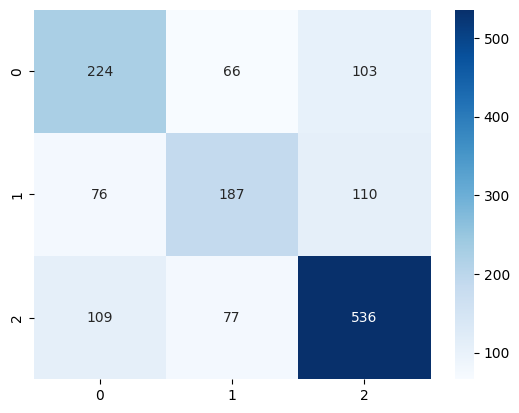

In [25]:
plot_confusion_matrix(labels_list_splitdata, predictions_list_splitdata)

In [26]:
# test some cases
p_tuning_model_splitdata_name = 'p_tuning-model-splitdata'
p_tuning_tokenizer_splitdata_name = 'p_tuning-tokenizer-splitdata'

# Save model
tokenizer.save_pretrained(p_tuning_tokenizer_splitdata_name)
model_p_tuning.save_pretrained(p_tuning_model_splitdata_name)

run_test_cases(p_tuning_model_splitdata_name, p_tuning_tokenizer_splitdata_name)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Example 1
The Committee anticipates that ongoing increases in the target range for the federal funds rate will be appropriate.
correct answer: Hawkish
predicted classification:  Dovish
Example 2
In light of the softer economic outlook, we will maintain the current federal funds rate.
correct answer: Dovish
predicted classification:  Dovish
Example 3
Economic activity has been rising at a strong rate.
correct answer: Neutral
predicted classification:  Neutral
Example 4
Considering the elevated inflation pressures, we may consider further rate hikes.
correct answer: Hawkish
predicted classification:  Hawkish
Example 5
The labor market continues to strengthen, but inflation remains below our 2 percent longer-run objective.
correct answer: Dovish
predicted classification:  Dovish
